# LA County Board of Supervisors - 2nd District Data Analysis

These maps visualize campaign donations made this campaign cycle to the three candidates running to replace Mark Ridley-Thomas on the Board of Supervisors, L.A. County's governing body. 

In [37]:
"""
A Los Angeles Times theme for Altair.
"""
# Color schemes and defaults
palette = dict(
    black='#000000',
    white='#ffffff',
    default='#82c6df',
    accent='#006d8f',
    highlight='#ec8431',
    democrat='#5789b8',
    republican='#d94f54',
    schemes={
      'category-6': [
        '#3580b1',
        '#ec8431',
        '#ab7fb4',
        '#c89d29',
        '#adc839',
        '#829eb1',
      ],
      'fire-7': [
        '#fbf2c7',
        '#f9e39c',
        '#f8d36e',
        '#f4bb6a',
        '#e68a4f',
        '#d15a40',
        '#ab4232',
      ],
      'fireandice-6': [
        '#e68a4f',
        '#f4bb6a',
        '#f9e39c',
        '#dadfe2',
        '#a6b7c6',
        '#849eae',
      ],
      'ice-7': [
        '#edefee',
        '#dadfe2',
        '#c4ccd2',
        '#a6b7c6',
        '#849eae',
        '#607785',
        '#47525d',
      ],
    }
)


def stiles():
    """
    A Los Angeles Times theme for Altair.
    """
    # Headline stuff
    headlineFontSize = 22
    headlineFontWeight = "normal"
    headlineFont = 'Benton Gothic Bold, sans'

    # Titles for axes and legends and such
    titleFont = 'Benton Gothic Bold, sans'
    titleFontWeight = 'normal'
    titleFontSize = 14

    # Labels for ticks and legend entries and such
    labelFont = 'Benton Gothic, sans'
    labelFontSize = 12
    labelFontWeight = 'normal'

    return dict(
        config=dict(
            view=dict(
                width=800,
                height=450
            ),
            background=palette['white'],
            title=dict(
                anchor='start',
                font=headlineFont,
                fontColor=palette['black'],
                fontSize=headlineFontSize,
                fontWeight=headlineFontWeight,
                Y=-5
            ),
            arc=dict(fill=palette['default']),
            area=dict(fill=palette['default']),
            line=dict(stroke=palette['default'], strokeWidth=3),
            path=dict(stroke=palette['default']),
            rect=dict(fill=palette['default']),
            shape=dict(stroke=palette['default']),
            bar=dict(fill=palette['default']),
            point=dict(stroke=palette['default']),
            symbol=dict(fill=palette['default'], size=30),
            axis=dict(
                titleFont=titleFont,
                titleFontSize=titleFontSize,
                titleFontWeight=titleFontWeight,
                labelFont=labelFont,
                labelFontSize=labelFontSize,
                labelFontWeight=labelFontWeight
            ),
            axisX=dict(
                labelAngle=0,
                labelPadding=4,
                tickSize=3
            ),
            axisY=dict(
                labelBaseline='middle',
                maxExtent=45,
                minExtent=45,
                tickSize=2,
                titleAlign='left',
                titleAngle=0,
                titleX=-45,
                titleY=-5
            ),
            legend=dict(
                titleFont=titleFont,
                titleFontSize=titleFontSize,
                symbolType='square',
                labelFont=labelFont,
                labelFontSize=labelFontSize + 1,
                labelFontWeight = 'bold'
            ),
            range=dict(
                category=palette['schemes']['category-6'],
                diverging=palette['schemes']['fireandice-6'],
                heatmap=palette['schemes']['fire-7'],
                ordinal=palette['schemes']['fire-7'],
                ramp=palette['schemes']['fire-7']
            )
        )
    )

In [2]:
import pandas as pd
import psycopg2 as pg
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
import sqlalchemy
import pandas.io.sql as psql
import numpy as np
import geopandas 
import descartes
import geojson
import scheme
import mapclassify
import json
import pysal as ps
import jenkspy
import altair as alt
import altair_latimes as lat
alt.renderers.enable('notebook')
# alt.themes.register('latimes', lat.theme)
# alt.themes.enable('latimes')

# register the custom theme under a chosen name
alt.themes.register('stiles', stiles)
# enable the newly registered theme
alt.themes.enable('stiles')


/Users/mhustiles/.virtualenvs/donations/lib/python3.6/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/Users/mhustiles/.virtualenvs/donations/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


ThemeRegistry.enable('stiles')

### Get the data from our larger donations database of committees in all countywide races back to 2007. 

In [3]:
database_con = pg.connect("dbname=campaigns user=postgres")

In [4]:
alldonations =  psql.read_sql("SELECT * FROM contributions", database_con)

### Let's clean up the spaces and capitalization in field names

In [5]:
alldonations.columns = alldonations.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [6]:
alldonations.head(2)

last_name first_name committee_id                      committee_name  \
0    Barger    Kathryn      1414462  Kathryn Barger for Supervisor 2020   
1    Barger    Kathryn      1414462  Kathryn Barger for Supervisor 2020   

  office_type district_number schedule   type        date  amount_rcvd  ...  \
0         CSU             C05        A  Other  2018-12-31       1500.0  ...   
1         CSU             C05        A  Other  2018-12-31       1500.0  ...   

   employer int_name int_city int_state int_zip_code int_occupation  \
0                                                                     
1                                                                     

  int_employer doc_id rec_id       x  
0                       2557  164858  
1                       2557  164916  

[2 rows x 31 columns]

### Some date parsing

In [7]:
alldonations['date'] = pd.to_datetime(alldonations['date'], errors='coerce')

In [8]:
alldonations['year'], alldonations['month'] = alldonations['date'].dt.year, alldonations['date'].dt.month
alldonations['year'] = alldonations['year'].astype(str)
alldonations['month'] = alldonations['month'].astype(str)
alldonations['amount_rcvd'] = alldonations['amount_rcvd'].astype(int)
alldonations['monthyear'] = pd.to_datetime(alldonations['date']).map(lambda dt: dt.replace(day=1))
alldonations['candidate'] = alldonations['first_name'] + ' ' + alldonations['last_name']
alldonations['last_name'] = alldonations['last_name'].str.upper()
alldonations['committee_name'] = alldonations['committee_name'].str.upper()
alldonations['first_name'] = alldonations['first_name'].str.upper()
alldonations['months'] = alldonations['date'].dt.strftime('%m/%Y').astype(str)


In [9]:
alldonations

last_name first_name committee_id  \
0        BARGER    KATHRYN      1414462   
1        BARGER    KATHRYN      1414462   
2      NAJARIAN  ARA JAMES      1376291   
3         LACEY  JACQUELYN      1334856   
4        WESSON       HERB      1414475   
...         ...        ...          ...   
77427    COOLEY      STEVE      1293554   
77428    COOLEY      STEVE      1293554   
77429    COOLEY      STEVE      1293554   
77430    COOLEY      STEVE      1293554   
77431  MITCHELL   HOLLY J.      1415889   

                                        committee_name office_type  \
0                   KATHRYN BARGER FOR SUPERVISOR 2020         CSU   
1                   KATHRYN BARGER FOR SUPERVISOR 2020         CSU   
2      NAJARIAN FOR LOS ANGELES COUNTY SUPERVISOR 2016         CSU   
3          COMMITTEE TO ELECT JACKIE LACEY FOR DA 2012         DAT   
4                           WESSON FOR SUPERVISOR 2020         CSU   
...                                                ...         ...   
77427          COMMITTEE TO RE-ELECT D.A. STEVE COOLEY         DAT   
77428          COMMITTEE TO RE-ELECT D.A. STEVE COOLEY         DAT   
77429          COMMITTEE TO RE-ELECT D.A. STEVE COOLEY         DAT   
77430          COMMITTEE TO RE-ELECT D.A. STEVE COOLEY         DAT   
77431     HOLLY J. MITCHELL FOR COUNTY SUPERVISOR 2020         CSU   

      district_number schedule   type       date  amount_rcvd  ...  \
0                 C05        A  Other 2018-12-31         1500  ...   
1                 C05        A  Other 2018-12-31         1500  ...   
2                 C05        A  Other 2016-04-22         1500  ...   
3                 N/A        A  Other 2012-10-04         1000  ...   
4                 C02        A  Other 2019-04-29         1500  ...   
...               ...      ...    ...        ...          ...  ...   
77427             Cna        A  Other 2007-02-23         1000  ...   
77428             Cna        A  Other 2007-02-21         1000  ...   
77429             Cna        A  Other 2007-02-19          750  ...   
77430             Cna        A  Other 2007-02-16         1000  ...   
77431             C02        A  Other 2019-02-28          750  ...   

       int_occupation int_employer doc_id rec_id       x  year month  \
0                                           2557  164858  2018    12   
1                                           2557  164916  2018    12   
2                                           2302  154849  2016     4   
3                                           1630   88438  2012    10   
4                                           2581  167892  2019     4   
...               ...          ...    ...    ...     ...   ...   ...   
77427                                         33    3971  2007     2   
77428                                         33    3738  2007     2   
77429                                         33    3997  2007     2   
77430                                         33    3807  2007     2   
77431                                       2578  165850  2019     2   

       monthyear           candidate   months  
0     2018-12-01      Kathryn Barger  12/2018  
1     2018-12-01      Kathryn Barger  12/2018  
2     2016-04-01  Ara James Najarian  04/2016  
3     2012-10-01     Jacquelyn Lacey  10/2012  
4     2019-04-01         Herb Wesson  04/2019  
...          ...                 ...      ...  
77427 2007-02-01        Steve Cooley  02/2007  
77428 2007-02-01        Steve Cooley  02/2007  
77429 2007-02-01        Steve Cooley  02/2007  
77430 2007-02-01        Steve Cooley  02/2007  
77431 2019-02-01   Holly J. Mitchell  02/2019  

[77432 rows x 36 columns]

### Filter out older contributions.

In [10]:
nudonations = alldonations[alldonations.date > '2018-06-30']

### Aggregate by month/year to make sure we filter appropriately. 

In [11]:
nudonations[['date', 'amount_rcvd']].groupby(nudonations.date.dt.to_period("M")).agg(['sum', 'size', 'mean'])

amount_rcvd                   
                sum  size         mean
date                                  
2018-07       87659   150   584.393333
2018-08      232188   323   718.848297
2018-09      304368   473   643.484144
2018-10      609077   803   758.501868
2018-11      176696   207   853.603865
2018-12      859396   700  1227.708571
2019-01      179180   187   958.181818
2019-02      607890   697   872.152080
2019-03      479805   509   942.642436
2019-04      419783   563   745.618117
2019-05      545495   706   772.655807
2019-06     1003559  1398   717.853362

## Three stories: Group 2020 contributions data by 1) race, 2) time, 3) zip code.

### Select only donations to candidates running in District 2

In [12]:
thiscycle = nudonations[(nudonations['date'] > '2018-06-30')]
district_two_candidates = (['PERRY','WESSON','MITCHELL'])
thiscycle = thiscycle[thiscycle['last_name'].isin(district_two_candidates)]

In [13]:
thiscycle.groupby('candidate').agg(['sum', 'size', 'mean'])

amount_rcvd                   amount_pd          
                          sum size         mean       sum size mean
candidate                                                          
Herb Wesson           1119445  960  1166.088542       0.0  960  0.0
Holly J. Mitchell      564594  767   736.106910       0.0  767  0.0
JAN PERRY              509760  893   570.839866       0.0  893  0.0

In [14]:
thiscycle.head(3)

last_name first_name committee_id              committee_name office_type  \
4     WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
71    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
72    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   

   district_number schedule       type       date  amount_rcvd  ...  \
4              C02        A      Other 2019-04-29         1500  ...   
71             N/A        A  Committee 2018-12-31         1500  ...   
72             N/A        A  Committee 2018-12-31         1500  ...   

    int_occupation int_employer doc_id rec_id       x  year month  monthyear  \
4                                        2581  167892  2019     4 2019-04-01   
71                                       2546  164456  2018    12 2018-12-01   
72                                       2546  164634  2018    12 2018-12-01   

      candidate   months  
4   Herb Wesson  04/2019  
71  Herb Wesson  12/2018  
72  Herb Wesson  12/2018  

[3 rows x 36 columns]

In [15]:
thiscycletrim = thiscycle[[
    'last_name',
    'first_name',
    'committee_id',
    'committee_name',
    'office_type',
    'district_number',
    'schedule',
    'type',
    'date',
    'amount_rcvd',
    'description',
    'contributor_first_name',
    'contributor_last_name',
    'contributor_address',
    'contributor_city',
    'contributor_state',
    'contributor_zip_code',
    'occupation',
    'employer',
    'doc_id',
    'rec_id',
    'year',
    'month',
    'months'
]]

# EXPORT FOR 'THISCYCLE' TABLE

In [16]:
thiscycletrim.to_csv("/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/thiscycle.csv", index=False)

***

### 1) Create a dataframe with summary stats for each campaign this cycle

In [17]:
thiscycletotals = thiscycle.groupby(['first_name','last_name', 'committee_name'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

### 1) Clean up the hierarchical column structure. Standardize names in all caps.

In [18]:
flat_columns = [''.join(t) for t in thiscycletotals.columns]
thiscycletotals.columns = flat_columns
thiscycletotals['amount_rcvdmean'] = thiscycletotals['amount_rcvdmean'].astype(int)
thiscycletotals['amount_rcvdmean'] = thiscycletotals['amount_rcvdmean'].round()
thiscycletotals['last_name'] = thiscycletotals['last_name'].str.upper()
thiscycletotals['committee_name'] = thiscycletotals['committee_name'].str.upper()
thiscycletotals['first_name'] = thiscycletotals['first_name'].str.upper()
thiscycletotals

first_name last_name                                committee_name  \
0       HERB    WESSON                    WESSON FOR SUPERVISOR 2020   
1   HOLLY J.  MITCHELL  HOLLY J. MITCHELL FOR COUNTY SUPERVISOR 2020   
2        JAN     PERRY      JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2   

   amount_rcvdsize  amount_rcvdmean  amount_rcvdsum  
0              960             1166         1119445  
1              767              736          564594  
2              893              570          509760

# EXPORT FOR 'THISCYCLETOTALS' TABLE

In [19]:
thiscycletotals.to_csv("/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/thiscycletotals.csv", index=False)

***

## 2) When were the donations given during the time period?

In [20]:
thiscycletime = thiscycle.groupby(['monthyear','year','month', 'last_name'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

In [21]:
thiscycletime
flat_columns = [''.join(t) for t in thiscycletime.columns]
thiscycletime.columns = flat_columns
thiscycletime['amount_rcvdmean'] = thiscycletime['amount_rcvdmean'].astype(int)
thiscycletime['amount_rcvdmean'] = thiscycletime['amount_rcvdmean'].round()
thiscycletime.head(10)
thiscycletime['months'] = thiscycletime['monthyear'].dt.strftime('%m/%d/%Y').astype(str)
thiscycletime

monthyear  year month last_name  amount_rcvdsize  amount_rcvdmean  \
0  2018-12-01  2018    12    WESSON              357             1275   
1  2019-01-01  2019     1     PERRY               59              642   
2  2019-01-01  2019     1    WESSON               78             1048   
3  2019-02-01  2019     2  MITCHELL              477              837   
4  2019-02-01  2019     2     PERRY               94              839   
5  2019-02-01  2019     2    WESSON               36             1031   
6  2019-03-01  2019     3  MITCHELL               19              546   
7  2019-03-01  2019     3     PERRY              112              670   
8  2019-03-01  2019     3    WESSON              143             1192   
9  2019-04-01  2019     4  MITCHELL               83              527   
10 2019-04-01  2019     4     PERRY              126              534   
11 2019-04-01  2019     4    WESSON               99             1096   
12 2019-05-01  2019     5  MITCHELL               45              575   
13 2019-05-01  2019     5     PERRY               93              556   
14 2019-05-01  2019     5    WESSON               95             1056   
15 2019-06-01  2019     6  MITCHELL              143              593   
16 2019-06-01  2019     6     PERRY              409              485   
17 2019-06-01  2019     6    WESSON              152             1090   

    amount_rcvdsum      months  
0           455299  12/01/2018  
1            37930  01/01/2019  
2            81800  01/01/2019  
3           399665  02/01/2019  
4            78875  02/01/2019  
5            37150  02/01/2019  
6            10375  03/01/2019  
7            75150  03/01/2019  
8           170550  03/01/2019  
9            43800  04/01/2019  
10           67325  04/01/2019  
11          108596  04/01/2019  
12           25895  05/01/2019  
13           51725  05/01/2019  
14          100325  05/01/2019  
15           84859  06/01/2019  
16          198755  06/01/2019  
17          165725  06/01/2019

### Individual dataframes for each candidate

In [22]:
bargerall = thiscycle[(thiscycle.last_name == 'Barger')]
hahnall = thiscycle[(thiscycle.last_name == 'Hahn')]
perryall = thiscycle[(thiscycle.last_name == 'PERRY')]
wessonall = thiscycle[(thiscycle.last_name == 'Wesson')]
iniguezall = thiscycle[(thiscycle.last_name == 'Iniguez')]
jeongall = thiscycle[(thiscycle.last_name == 'Jeong')]
mitchellall = thiscycle[(thiscycle.last_name == 'Mitchell')]

## Let's make some charts
### Totals donations collected by 2020 supervisor candidates since last summer

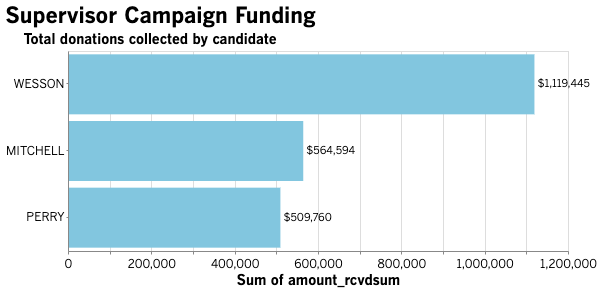

In [23]:
bars = alt.Chart(thiscycletotals, title="Supervisor Campaign Funding").mark_bar().encode(
    x='sum(amount_rcvdsum):Q',
    y=alt.Y(
        'last_name:N',
        title="Total donations collected by candidate",
        sort=alt.EncodingSortField(
            field="amount_rcvdsum",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
    )
)
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdsum:Q', format="$,")
)
    
(bars + text).properties(height=200, width=500)

### What's the average donation size? 

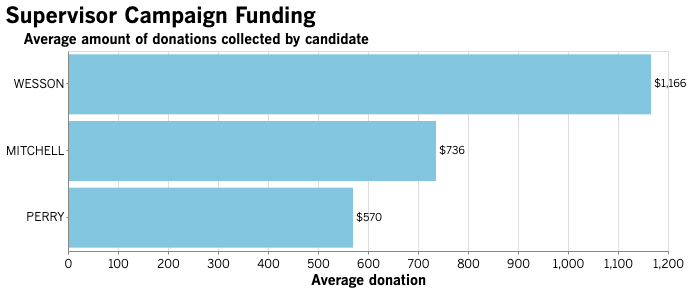

In [24]:
bars = alt.Chart(thiscycletotals, title="Supervisor Campaign Funding").mark_bar().encode(
    x=alt.X(
        'sum(amount_rcvdmean):Q',
        title="Average donation"),
    y=alt.Y(
        'last_name:N',
        title="Average amount of donations collected by candidate",
        sort=alt.EncodingSortField(
            field="amount_rcvdmean",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
    )
)
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdmean:Q', format="$,")
)
    
(bars + text).properties(height=200, width=600)

### How many donations have the candidates received? 

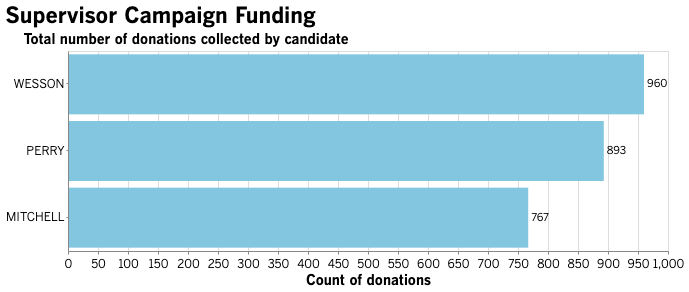

In [25]:
bars = alt.Chart(thiscycletotals, title="Supervisor Campaign Funding").mark_bar().encode(
    x=alt.X(
        'sum(amount_rcvdsize):Q',
        title="Count of donations"),
    y=alt.Y(
        'last_name:N',
        title="Total number of donations collected by candidate",
        sort=alt.EncodingSortField(
            field="amount_rcvdsize",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
        )
    )
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdsize:Q', format=",")
)
    
(bars + text).properties(height=200, width=600)

### Sum of donations by month

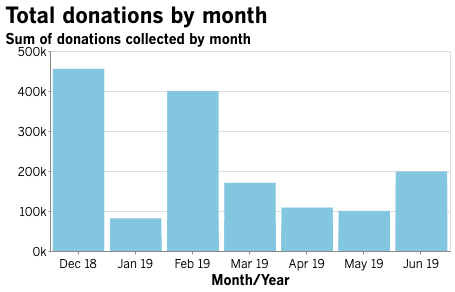

In [26]:
bars = alt.Chart(thiscycletime, title="Total donations by month").mark_bar().encode(
    x=alt.X("months:O", 
            timeUnit="yearmonth",
            title="Month/Year",
            axis=alt.Axis(format="%b %y")
           ),
    y=alt.Y(
        'amount_rcvdsum:Q',
        title="Sum of donations collected by month",
        axis=alt.Axis(format="1s")
        )
    )

(bars).properties(height=200, width=400) 

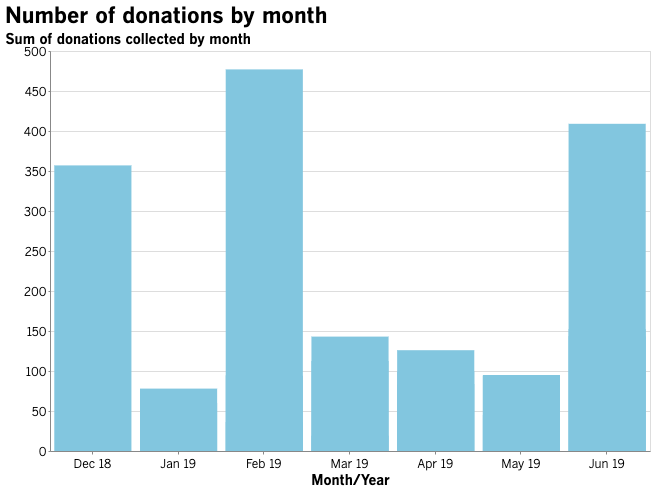

In [27]:
bars = alt.Chart(thiscycletime, title="Number of donations by month").mark_bar().encode(
    x=alt.X("months:O", 
            timeUnit="yearmonth",
            title="Month/Year",
            axis=alt.Axis(format="%b %y")
           ),
    y=alt.Y(
        'amount_rcvdsize:Q',
        title="Sum of donations collected by month",
        sort=alt.EncodingSortField(
            field="amount_rcvdsize",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
        )
    )
)

(bars).properties(height=400, width=600)

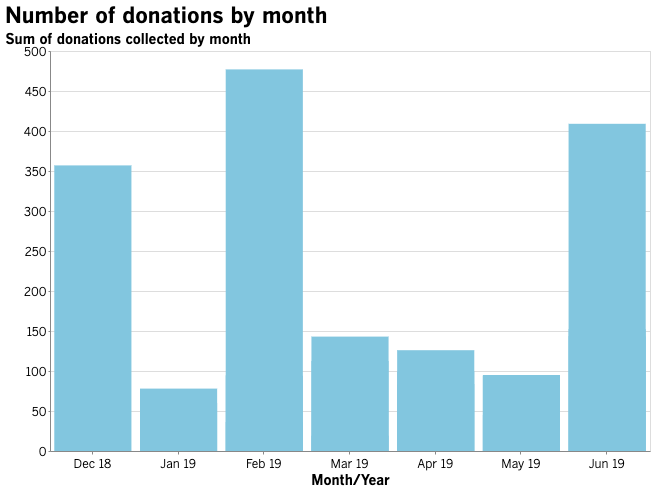

In [28]:
bars = alt.Chart(thiscycletime, title="Number of donations by month").mark_bar().encode(
    x=alt.X("months:O", 
            timeUnit="yearmonth",
            title="Month/Year",
            axis=alt.Axis(format="%b %y")
           ),
    y=alt.Y(
        'amount_rcvdsize:Q',
        title="Sum of donations collected by month",
        sort=alt.EncodingSortField(
            field="amount_rcvdsize",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
        )
    )
)

(bars).properties(height=400, width=600)

In [29]:
thiscycletime

monthyear  year month last_name  amount_rcvdsize  amount_rcvdmean  \
0  2018-12-01  2018    12    WESSON              357             1275   
1  2019-01-01  2019     1     PERRY               59              642   
2  2019-01-01  2019     1    WESSON               78             1048   
3  2019-02-01  2019     2  MITCHELL              477              837   
4  2019-02-01  2019     2     PERRY               94              839   
5  2019-02-01  2019     2    WESSON               36             1031   
6  2019-03-01  2019     3  MITCHELL               19              546   
7  2019-03-01  2019     3     PERRY              112              670   
8  2019-03-01  2019     3    WESSON              143             1192   
9  2019-04-01  2019     4  MITCHELL               83              527   
10 2019-04-01  2019     4     PERRY              126              534   
11 2019-04-01  2019     4    WESSON               99             1096   
12 2019-05-01  2019     5  MITCHELL               45              575   
13 2019-05-01  2019     5     PERRY               93              556   
14 2019-05-01  2019     5    WESSON               95             1056   
15 2019-06-01  2019     6  MITCHELL              143              593   
16 2019-06-01  2019     6     PERRY              409              485   
17 2019-06-01  2019     6    WESSON              152             1090   

    amount_rcvdsum      months  
0           455299  12/01/2018  
1            37930  01/01/2019  
2            81800  01/01/2019  
3           399665  02/01/2019  
4            78875  02/01/2019  
5            37150  02/01/2019  
6            10375  03/01/2019  
7            75150  03/01/2019  
8           170550  03/01/2019  
9            43800  04/01/2019  
10           67325  04/01/2019  
11          108596  04/01/2019  
12           25895  05/01/2019  
13           51725  05/01/2019  
14          100325  05/01/2019  
15           84859  06/01/2019  
16          198755  06/01/2019  
17          165725  06/01/2019

***

# Which types of donors gave to the candidates? 

In [30]:
thiscycle.groupby(['type','last_name'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

type last_name amount_rcvd                     
                                                 size         mean     sum
0                     Committee  MITCHELL         138  1127.840580  155642
1                     Committee     PERRY           3   750.000000    2250
2                     Committee    WESSON          39  1365.384615   53250
3                    Individual  MITCHELL         447   465.102908  207901
4                    Individual     PERRY         794   545.415617  433060
5                    Individual    WESSON         617  1136.377634  701145
6                         Other  MITCHELL         163  1067.797546  174051
7                         Other     PERRY          96   775.520833   74450
8                         Other    WESSON         289  1194.636678  345250
9   Small Contributor Committee  MITCHELL          19  1421.052632   27000
10  Small Contributor Committee    WESSON          15  1320.000000   19800

## Share of the candidates' donations by type

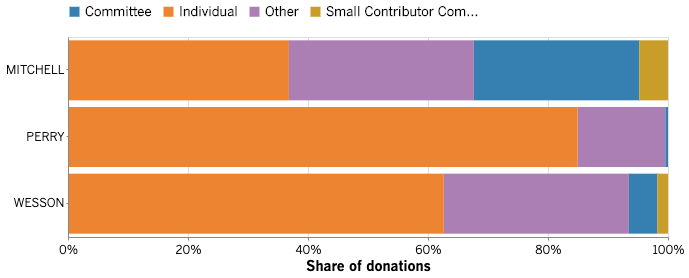

In [31]:
bars = alt.Chart(thiscycle, title='').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', stack="normalize", title="Share of donations",axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('last_name', title=""),
    color=alt.Color('type',legend=alt.Legend(title="", orient='top')),
    order=alt.Order('sum(amount_rcvd)', sort='descending')
)


(bars).properties(height=200, width=600)

## Which zip codes are in LA County

### Read in a list extracted from a spatial file

In [32]:
la_zipcodes = pd.read_csv('/Users/mhustiles/Desktop/github/la-supervisors-donations-2020/data/lazips_grouped.csv')

In [33]:
la_zips_list = la_zipcodes['zip_code'].to_csv(header=False, index=False).strip('\n').split('\n')

In [34]:
thiscycletrim.loc[thiscycletrim['contributor_zip_code'].isin(la_zips_list)]
thiscycle_la_zips = thiscycletrim.loc[thiscycletrim['contributor_zip_code'].isin(la_zips_list)]

In [35]:
thiscycletrim['lacounty'] = np.where(thiscycletrim['contributor_zip_code'].isin(la_zips_list), 'Inside LA County', 'Outside LA County')

/Users/mhustiles/.virtualenvs/donations/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Now, what share of each candidates' donations are from LA County?

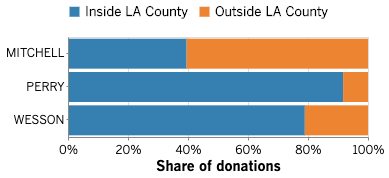

In [44]:
bars = alt.Chart(thiscycletrim, title='').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', stack="normalize", title="Share of donations", axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('last_name', title=""),
    color=alt.Color('lacounty',legend=alt.Legend(title="",orient='top')),
    order=alt.Order('lacounty', sort='ascending')
)


(bars).properties(height=100, width=300)

last_name first_name committee_id  \
4        WESSON       HERB      1414475   
71       WESSON       HERB      1414475   
72       WESSON       HERB      1414475   
113      WESSON       HERB      1414475   
114      WESSON       HERB      1414475   
...         ...        ...          ...   
76301    WESSON       HERB      1414475   
76302    WESSON       HERB      1414475   
76303    WESSON       HERB      1414475   
76304    WESSON       HERB      1414475   
77431  MITCHELL   HOLLY J.      1415889   

                                     committee_name office_type  \
4                        WESSON FOR SUPERVISOR 2020         CSU   
71                       WESSON FOR SUPERVISOR 2020         CSU   
72                       WESSON FOR SUPERVISOR 2020         CSU   
113                      WESSON FOR SUPERVISOR 2020         CSU   
114                      WESSON FOR SUPERVISOR 2020         CSU   
...                                             ...         ...   
76301                    WESSON FOR SUPERVISOR 2020         CSU   
76302                    WESSON FOR SUPERVISOR 2020         CSU   
76303                    WESSON FOR SUPERVISOR 2020         CSU   
76304                    WESSON FOR SUPERVISOR 2020         CSU   
77431  HOLLY J. MITCHELL FOR COUNTY SUPERVISOR 2020         CSU   

      district_number schedule        type       date  amount_rcvd  ...  \
4                 C02        A       Other 2019-04-29         1500  ...   
71                N/A        A   Committee 2018-12-31         1500  ...   
72                N/A        A   Committee 2018-12-31         1500  ...   
113               N/A        A       Other 2018-12-31          250  ...   
114               N/A        A       Other 2018-12-31          800  ...   
...               ...      ...         ...        ...          ...  ...   
76301             C02        A  Individual 2019-05-16          250  ...   
76302             C02        A  Individual 2019-06-26         1500  ...   
76303             C02        A  Individual 2019-02-22          500  ...   
76304             C02        A  Individual 2019-04-09         1500  ...   
77431             C02        A       Other 2019-02-28          750  ...   

      contributor_state contributor_zip_code       occupation  \
4                    CA                92780                    
71                   CA                95815                    
72                   CA                90017                    
113                  CA                90066                    
114                  CA                90020                    
...                 ...                  ...              ...   
76301                CA                90232    Administrator   
76302                CA                90021            Sales   
76303                CA                90062  President & CEO   
76304                CA                91307          Retired   
77431                CA                95695                    

                          employer doc_id rec_id  year month   months  \
4                                           2581  2019     4  04/2019   
71                                          2546  2018    12  12/2018   
72                                          2546  2018    12  12/2018   
113                                         2546  2018    12  12/2018   
114                                         2546  2018    12  12/2018   
...                            ...    ...    ...   ...   ...      ...   
76301  Loyola Marymount University          2581  2019     5  05/2019   
76302                 United Melon          2581  2019     6  06/2019   
76303              The Zaman Group          2581  2019     2  02/2019   
76304                          N/A          2581  2019     4  04/2019   
77431                                       2578  2019     2  02/2019   

                lacounty  
4      Outside LA County  
71     Outside LA County  
72      Inside LA County  
113     Inside LA